# Modelo XGBRegressor

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/iA/Data_PC2/
%ls

Mounted at /gdrive
/gdrive/MyDrive/iA/Data_PC2
 data             data2.csv.yaml        data_final.csv.yaml   train_data.csv
'data2 (1).csv'   data.csv              data_final.hdf5
 data2.csv        data_final.csv        train.csv
 data2.csv.hdf5   data_final.csv.hdf5   train.csv.hdf5


Importamos las librerias necesarias para ejecutar el modelo XGBRegressor

In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

Se importa la data limpia

In [4]:
df = pd.read_csv("train_data.csv")

In [5]:
df.head()

,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta,year,aeropuerto,day_of_month
0,2014-02-19 07:22:00.00000074,2014-02-19 07:22:00 UTC,40.760465,-73.986430,40.737075,-73.988990,1,12.50,2,7.366667,8,0,0,2014,0,19
1,2014-12-06 20:36:22.0000008,2014-12-06 20:36:22 UTC,40.751902,-73.979815,40.755481,-73.979446,1,4.00,5,20.600000,49,1,1,2014,0,6
2,2014-02-19 16:03:00.000000160,2014-02-19 16:03:00 UTC,40.752422,-73.976075,40.759285,-73.981082,1,5.50,2,16.050000,8,0,1,2014,0,19
3,2015-06-21 21:46:34.0000001,2015-06-21 21:46:34 UTC,40.717667,-74.010483,40.660366,-73.985771,1,22.54,6,21.766667,25,1,0,2015,0,21
4,2015-01-11 03:15:38.0000001,2015-01-11 03:15:38 UTC,40.738720,-73.983330,40.847225,-73.933197,1,58.00,6,3.250000,2,1,0,2015,0,11


Cambiamos el año que es una variable categorica y convertimos en una variable numerica.

In [6]:
df = pd.get_dummies(df, columns=['year'])

In [7]:
df.head()

,key,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount,day,hour,week,trayecto_nocturno,hora_punta,aeropuerto,day_of_month,year_2014,year_2015
0,2014-02-19 07:22:00.00000074,2014-02-19 07:22:00 UTC,40.760465,-73.986430,40.737075,-73.988990,1,12.50,2,7.366667,8,0,0,0,19,1,0
1,2014-12-06 20:36:22.0000008,2014-12-06 20:36:22 UTC,40.751902,-73.979815,40.755481,-73.979446,1,4.00,5,20.600000,49,1,1,0,6,1,0
2,2014-02-19 16:03:00.000000160,2014-02-19 16:03:00 UTC,40.752422,-73.976075,40.759285,-73.981082,1,5.50,2,16.050000,8,0,1,0,19,1,0
3,2015-06-21 21:46:34.0000001,2015-06-21 21:46:34 UTC,40.717667,-74.010483,40.660366,-73.985771,1,22.54,6,21.766667,25,1,0,0,21,0,1
4,2015-01-11 03:15:38.0000001,2015-01-11 03:15:38 UTC,40.738720,-73.983330,40.847225,-73.933197,1,58.00,6,3.250000,2,1,0,0,11,0,1


Separamos nuestros datos donde: X son las variables predicatoras , y la variable objetivo.

In [8]:
X = df.drop(['key',	'pickup_datetime', 'fare_amount'], axis=1)
y = df[['fare_amount']]

In [9]:
X.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,day,hour,week,trayecto_nocturno,hora_punta,aeropuerto,day_of_month,year_2014,year_2015
0,40.760465,-73.986430,40.737075,-73.988990,1,2,7.366667,8,0,0,0,19,1,0
1,40.751902,-73.979815,40.755481,-73.979446,1,5,20.600000,49,1,1,0,6,1,0
2,40.752422,-73.976075,40.759285,-73.981082,1,2,16.050000,8,0,1,0,19,1,0
3,40.717667,-74.010483,40.660366,-73.985771,1,6,21.766667,25,1,0,0,21,0,1
4,40.738720,-73.983330,40.847225,-73.933197,1,6,3.250000,2,1,0,0,11,0,1


## Diagrama 

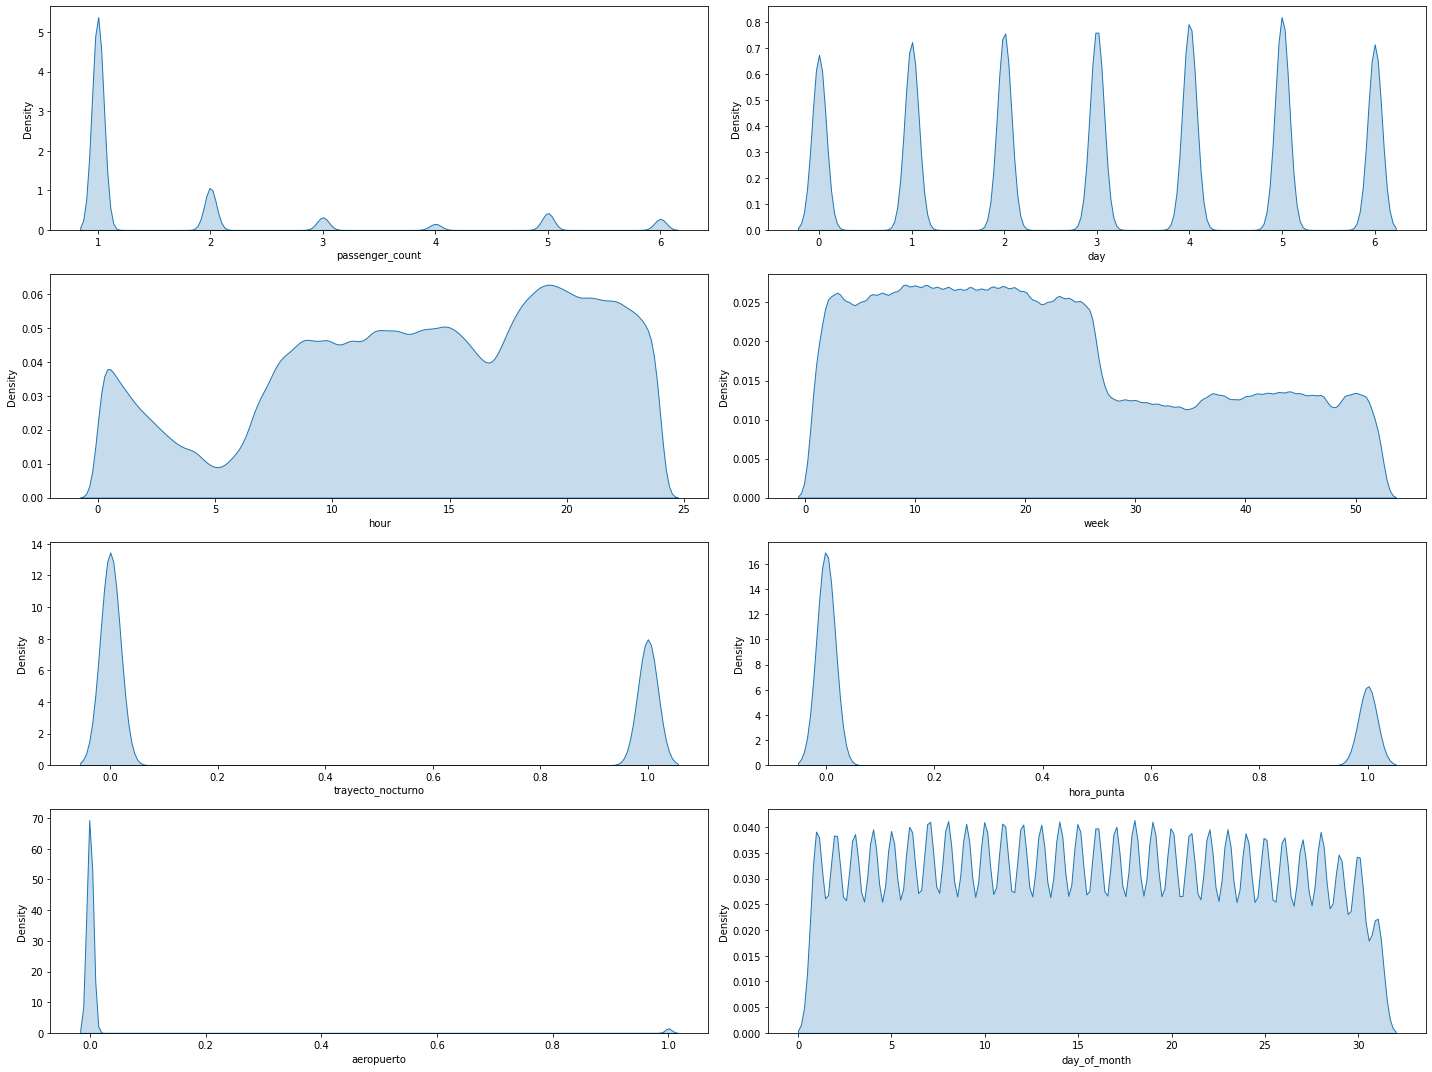

In [14]:
fig, axes = plt.subplots(figsize=(20,15), ncols=2, nrows=4)
sns.kdeplot(X['passenger_count'], shade=True, ax=axes[0,0])
sns.kdeplot(X['day'], shade=True, ax=axes[0,1])
sns.kdeplot(X['hour'], shade=True, ax=axes[1,0])
sns.kdeplot(X['week'], shade=True, ax=axes[1,1])
sns.kdeplot(X['trayecto_nocturno'], shade=True, ax=axes[2,0])
sns.kdeplot(X['hora_punta'], shade=True, ax=axes[2,1])
sns.kdeplot(X['aeropuerto'], shade=True, ax=axes[3,0])
sns.kdeplot(X['day_of_month'], shade=True, ax=axes[3,1])
plt.tight_layout()

Realizamos el preprocesamiento

In [9]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
scaler = MinMaxScaler()
normalizer = Normalizer()

coordenadas = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
tiempo  = ['day', 'hour','week', 'day_of_month']
numericas = ['passenger_count','trayecto_nocturno','hora_punta','aeropuerto','year_2014',	'year_2015']

dfc = pd.DataFrame(scaler.fit_transform(X[coordenadas]), columns = coordenadas)
dft = pd.DataFrame(normalizer.fit_transform(X[tiempo]), columns= tiempo)

In [10]:
X = pd.concat([dfc, dft, df[numericas]],axis=1)
X.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,day,hour,week,day_of_month,passenger_count,trayecto_nocturno,hora_punta,aeropuerto,year_2014,year_2015
0,0.732555,0.393240,0.468464,0.845574,0.090978,0.335102,0.363912,0.864290,1,0,0,0,1,0
1,0.732398,0.393294,0.469529,0.845742,0.093067,0.383435,0.912055,0.111680,1,1,1,0,1,0
2,0.732408,0.393325,0.469749,0.845713,0.076327,0.612523,0.305307,0.725105,1,0,1,0,1,0
3,0.731772,0.393043,0.464029,0.845630,0.151148,0.548331,0.629783,0.529018,1,1,0,0,0,1
4,0.732157,0.393266,0.474833,0.846558,0.458079,0.248126,0.152693,0.839811,1,1,0,0,0,1


Dividimos la data total en 70% de para el entrenamiento y el 30% para la prueba.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1000)

## Realizamos un primer entrenamiento con el modelo XGBRegressor

In [12]:
reg_model = XGBRegressor(
    max_depth = 9,
    learning_rate = 0.6,
    silent  = True,
    objective = 'reg:squarederror',
    booster = 'gbtree',
    nthread = -1,
    subsample = 0.8,
    colsample_bytree  =1.0, 
    colsample_bylevel =0.9, 
    seed              =2019,
    missing           =0.0, 
)

In [13]:
model = reg_model.fit(X=X_train,
                      y=y_train, 
                      sample_weight=np.ones(X_train.shape[0]),
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric = 'rmse',
                      early_stopping_rounds=10,
                      verbose=False,
                      xgb_model=None)

In [14]:
predict = model.predict(X_train)

In [15]:
mse_train = mean_squared_error(y_train, predict)
rmse_train = np.sqrt(mse_train)
print("RMSE para el train {}".format(rmse_train))

RMSE para el train 3.2831594683002447


In [16]:
predict = model.predict(X_test)

In [17]:
mse_test = mean_squared_error(y_test, predict)
rmse_test = np.sqrt(mse_test)
print("RMSE para el test {}".format(rmse_test))

RMSE para el train 3.4822300762412004


In [18]:
print("score: {:.3f}".format(model.score(X_train, y_train)))

score: 0.899


In [19]:
print("score: {:.3f}".format(model.score(X_test, y_test)))

score: 0.887


Grafico donde se ve las caracteristicas importantes de cada caracteristicas.

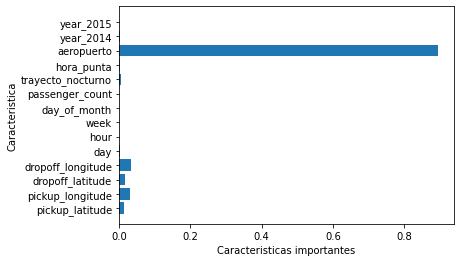

In [20]:
def dibuja_caracteristicas_importantes(modelo):
    n_caracteristica = X.shape[1]
    plt.barh(range(n_caracteristica), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_caracteristica),list(X.columns))
    plt.xlabel("Caracteristicas importantes")
    plt.ylabel("Caracteristica")

dibuja_caracteristicas_importantes(model)

## Ahora usamos con una Grilla Simple para encontrar en mejor parametro

Dividimos la data :


*   X_trainval , X_test, y_trainval, y_test : en una proporción de de 70 - 30.
*   X_train, X_val, y_train, y_val : en una proporción de 70 - 30.



In [22]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3,random_state=100)

In [23]:
mejor_puntuacion  = 0

for max_depth in  [7, 8, 9]:
  for learning_rate in [0.3, 0.4, 0.5]:

    reg_model = XGBRegressor(
        max_depth = max_depth,
        learning_rate = learning_rate,
        silent  = True,
        objective = 'reg:squarederror',
        booster = 'gbtree',
        n_jobs  = multiprocessing.cpu_count()-1,
        subsample = 0.8,
        colsample_bytree  =1.0, 
        colsample_bylevel =0.9, 
        seed              =100
    )

    model = reg_model.fit(X=X_train,
                          y=y_train, 
                          sample_weight=np.ones(X_train.shape[0]),
                          eval_set=[(X_val, y_val)],
                          eval_metric = 'rmse',
                          early_stopping_rounds=10,
                          verbose=False,
                          xgb_model=None)
    
    puntuacion  = model.score(X_val, y_val)
    print("score {:.3f} con max_depth {:.3f} ".format(puntuacion ,max_depth))

    if puntuacion > mejor_puntuacion:
      mejor_puntuacion  = puntuacion
      mejor_parametro = {'max_depth':max_depth,
                         'learning_rate':learning_rate}

print("Mejor puntuacion {:.3f}".format(mejor_puntuacion))


score 0.885 con max_depth 7.000 
score 0.885 con max_depth 7.000 
score 0.886 con max_depth 7.000 
score 0.888 con max_depth 8.000 
score 0.887 con max_depth 8.000 
score 0.887 con max_depth 8.000 
score 0.890 con max_depth 9.000 
score 0.889 con max_depth 9.000 
score 0.888 con max_depth 9.000 
Mejor puntuacion 0.890


In [24]:
print("Mejor parametro: {}".format(mejor_parametro))

Mejor parametro: {'max_depth': 9, 'learning_rate': 0.3}


In [25]:
reg_model = XGBRegressor(
        max_depth = 9,
        learning_rate = 0.3,
        silent  = True,
        objective = 'reg:squarederror',
        booster = 'gbtree',
        n_jobs  = multiprocessing.cpu_count()-1,
        subsample = 0.8,
        colsample_bytree  =1.0, 
        colsample_bylevel =0.9, 
        seed              =100
    )
model = reg_model.fit(X=X_train,
                          y=y_train, 
                          sample_weight=np.ones(X_train.shape[0]),
                          eval_set=[(X_test, y_test)],
                          eval_metric = 'rmse',
                          early_stopping_rounds=10,
                          verbose=False,
                          xgb_model=None)

print("score de train {:.3f} ".format(model.score(X_train, y_train)))
print("score de test {:.3f} ".format(model.score(X_test, y_test)))

predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, predict_train)
rmse_train = np.sqrt(mse_train)
print("RMSE para el train {}".format(rmse_train))

mse_test = mean_squared_error(y_test, predict_test)
rmse_test = np.sqrt(mse_test)
print("RMSE para el test {}".format(rmse_test))

score de train 0.898 
score de test 0.890 
RMSE para el train 3.294361919713386
RMSE para el test 3.430641474313749


Grafica donde se aprecia las caracteristicas mas importantes.

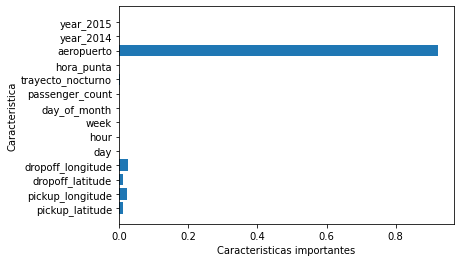

In [26]:
dibuja_caracteristicas_importantes(model)